In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-dataset/reports.csv
/kaggle/input/cxr-dataset/projections.csv
/kaggle/input/cxr-dataset/images/349_IM-1697-2001.dcm.png
/kaggle/input/cxr-dataset/images/607_IM-2196-1001.dcm.png
/kaggle/input/cxr-dataset/images/2832_IM-1249-2001.dcm.png
/kaggle/input/cxr-dataset/images/699_IM-2263-2001.dcm.png
/kaggle/input/cxr-dataset/images/1931_IM-0602-2001.dcm.png
/kaggle/input/cxr-dataset/images/947_IM-2442-2001.dcm.png
/kaggle/input/cxr-dataset/images/2932_IM-1335-1001.dcm.png
/kaggle/input/cxr-dataset/images/2303_IM-0882-1001.dcm.png
/kaggle/input/cxr-dataset/images/291_IM-1313-2001.dcm.png
/kaggle/input/cxr-dataset/images/1790_IM-0515-1001.dcm.png
/kaggle/input/cxr-dataset/images/3489_IM-1696-2001.dcm.png
/kaggle/input/cxr-dataset/images/3275_IM-1556-1002001.dcm.png
/kaggle/input/cxr-dataset/images/286_IM-1267-3001.dcm.png
/kaggle/input/cxr-dataset/images/3071_IM-1433-1001.dcm.png
/kaggle/input/cxr-dataset/images/1991_IM-0648-1001.dcm.png
/kaggle/input/cxr-dataset/images/3083_

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [6]:
from glob import glob
image_path = "/kaggle/input/cxr-dataset/images/"
images = glob(image_path + "*.png")
len(images)

7470

In [7]:
img_base_dir = '/kaggle/input/cxr-dataset/images'

In [8]:
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')
reports_df.head()


,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [9]:
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [10]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.impression.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        impression= self.reports_df.loc[uid]['impression']
        print(impression)
        return uid, images, projections, impression

In [11]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, impression = paired_dataset.get_sample()

No acute cardiopulmonary abnormalities.


In [12]:
def display_sample(uid, images, projections, impression):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(img_base_dir, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Impression:", impression)

UID: 1822


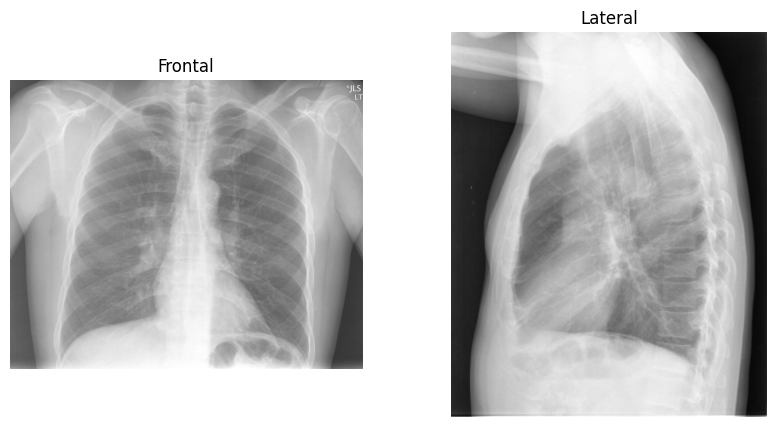

Impression: No acute cardiopulmonary abnormalities.


In [13]:
display_sample(uid, images, projections, impression)

In [14]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

In [15]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

In [16]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [17]:
impression_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].impression.dropna()]

In [18]:
pd.Series([len(x) for x in impression_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3440.000000
mean       17.939244
std        19.098879
min         2.000000
25%         8.000000
50%        10.000000
75%        21.000000
80%        26.000000
90%        42.000000
95%        57.000000
max       205.000000
dtype: float64

In [19]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

# Create dataset
dataset = GPT2Dataset(impression_corpus, max_length=128)  # Adjust max_length as needed
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

In [20]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [21]:
sample_reports = list(reports_df[reports_df.uid.isin(test_uids)].impression.dropna().sample(5))

In [22]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 No active disease.
Generated report:
 No active disease.

The study was published in the journal Nature Communications.
------------
Sample report:
 No radiographic evidence of acute cardiopulmonary disease
Generated report:
 No radiographic evidence of acute or chronic disease is available.

The most common cause of death in patients with chronic obstructive pulmonary disease (COPD) is pulmonary embolism. The most commonly reported cause is a pulmonary edema, which is caused by a buildup of fluid in the lungs. In patients who have COPD, the most likely cause may be a lack of oxygen, a high-pressure system, or a combination of these factors. Patients with COPDs may also have
------------
Sample report:
 1. No acute cardiopulmonary abnormalities
Generated report:
 1. No acute cardiopulmonary abnormalities.

2. A history of heart failure.


3. Anemia.
------------
Sample report:
 No acute process.
Generated report:
 No acute process.

The first step is to determine if the

In [23]:
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

NUM_EPOCHS = 3 # Having larger number of epochs here was leading to complete overfitting on the report content
for epoch in range(NUM_EPOCHS):
    for batch in tqdm.auto.tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} completed')

  0%|          | 0/860 [00:00<?, ?it/s]

Epoch 0 completed


  0%|          | 0/860 [00:00<?, ?it/s]

Epoch 1 completed


  0%|          | 0/860 [00:00<?, ?it/s]

Epoch 2 completed


In [24]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 No active disease.
Generated report:
 No active disease.
------------
Sample report:
 No radiographic evidence of acute cardiopulmonary disease
Generated report:
 No radiographic evidence of acute cardiopulmonary process.
------------
Sample report:
 1. No acute cardiopulmonary abnormalities
Generated report:
 1. No acute cardiopulmonary abnormalities.
------------
Sample report:
 No acute process.
Generated report:
 No acute process.
------------
Sample report:
 1. No evidence of active disease.
Generated report:
 1. No evidence of active disease.
------------


In [25]:
model.save_pretrained('/kaggle/working/gpt-2-model')
tokenizer.save_pretrained('/kaggle/working/gpt-2-tokenizer')

('/kaggle/working/gpt-2-tokenizer/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer/vocab.json',
 '/kaggle/working/gpt-2-tokenizer/merges.txt',
 '/kaggle/working/gpt-2-tokenizer/added_tokens.json')

In [26]:
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/working/gpt-2-tokenizer')

vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()

In [27]:
MAX_SEQ_LENGTH  = 128
MAX_IMG_STACK = 5+1
BATCH_SIZE = 4

In [28]:
class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, max_length=MAX_SEQ_LENGTH, max_img_stack=MAX_IMG_STACK):
        self.reports_df = reports_df.dropna(subset={'impression'}).set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = list(set(self.reports_df.index).intersection(self.projections_df.index))
        self.max_length = max_length
        self.max_img_stack = max_img_stack
        
    def __getitem__(self, index):
        uid = self.uids[index]
        image_paths = [os.path.join(img_base_dir, x) for x in list(self.projections_df.loc[[uid]]['filename'])]
        images = torch.stack([vision_preprocess(read_image(img ,ImageReadMode.RGB)) for img in image_paths])
        len_image_stack = len(image_paths)
        img_dim = images[0].shape
        images = torch.cat((torch.zeros((self.max_img_stack - len_image_stack, *img_dim)), images), dim=0)
        
        impression = tokenizer.encode(self.reports_df.loc[uid]['impression'])
        impression= torch.tensor(impression[:self.max_length-1]+ [tokenizer.eos_token_id])
        return len_image_stack, images, impression
    
    def __len__(self):
        return len(self.uids)
    
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    len_images = torch.tensor([item[0] for item in batch])
    img_data = torch.stack([item[1] for item in batch])
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
        
    tokens = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    labels = pad_sequence([torch.cat((torch.tensor([-100]*MAX_IMG_STACK), item[2])) for item in batch], batch_first=True, padding_value=pad_id) 
    return [len_images, img_data, tokens, labels, pad_sequence([torch.ones(len(item[2])+MAX_IMG_STACK) for item in batch], batch_first=True, padding_value=0)]

In [29]:
train_dataset = ImageCaptionData(reports_df[reports_df.uid.isin(train_uids)], projections_df[projections_df.uid.isin(train_uids)])
test_dataset = ImageCaptionData(reports_df[~reports_df.uid.isin(train_uids)], projections_df[~projections_df.uid.isin(train_uids)])

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [31]:
x = next(iter(train_dataloader))
x[0].shape, x[1].shape, x[2].shape, x[3].shape, x[4].shape

(torch.Size([4]),
 torch.Size([4, 6, 3, 224, 224]),
 torch.Size([4, 96]),
 torch.Size([4, 102]),
 torch.Size([4, 102]))

In [32]:
lang_model = GPT2LMHeadModel.from_pretrained('/kaggle/working/gpt-2-model')

In [33]:
vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
vision_model.head = nn.Identity() # strip off classification layer of swin transformer to get the image embedding

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 113MB/s] 


In [34]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

In [35]:
class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [36]:
projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [39]:
# freeze vision model
vision_model.eval()
for param in vision_model.parameters():
    param.requires_grad = False

In [40]:
optimizer = torch.optim.Adam(
    [
        {"params": lang_model.parameters(), "lr": 2e-5},
        {"params": projection_model.parameters(), "lr": 5e-5}
    ]
)

In [41]:
NUM_EPOCHS = 5

In [42]:
MODEL_CHECKPOINTS_PATH = '/kaggle/working/checkpoints'
if not os.path.exists(MODEL_CHECKPOINTS_PATH):
    os.makedirs(MODEL_CHECKPOINTS_PATH)

In [43]:
import pdb

In [44]:
best_val_loss = np.inf

In [45]:
train_loss = []
for i in range(NUM_EPOCHS):
    train_batch_loss = []
    
    lang_model.train()
    projection_model.train()
    for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(train_dataloader):
        img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            # refetching bos_embedding to handle cases where bos_embedding might be trainable as well
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0,1))
        
        img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
        img_embed = bos_embedding*mask + (1-mask)*img_embed # replace images that are not present with bos embedding

        tok_embed = lang_model.get_input_embeddings()(tokens)
        input_embed = torch.cat((img_embed, tok_embed), dim=1)
        outputs = lang_model(
                inputs_embeds=input_embed,
                labels=labels,
                attention_mask=attn,
            )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item()/len(l_img))
        
    train_loss.append(train_batch_loss)
    
    lang_model.eval()
    projection_model.eval()
    aggregated_val_loss = []
    with torch.no_grad():
        for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(test_dataloader):
            img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
            
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0,1))
        
            img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
            img_embed = bos_embedding*mask + (1-mask)*img_embed

            tok_embed = lang_model.get_input_embeddings()(tokens)
            input_embed = torch.cat((img_embed, tok_embed), dim=1)
            outputs = lang_model(
                    inputs_embeds=input_embed,
                    labels=labels,
                    attention_mask=attn,
                )

            loss = outputs.loss
            aggregated_val_loss.append(loss.item()/len(l_img))
    
    print("Epoch:", i, "Train Loss: {:.4f}".format(np.mean(train_batch_loss)), "Val Loss: {:.4f}".format(np.mean(aggregated_val_loss)))
    if (np.mean(aggregated_val_loss)<best_val_loss):
        best_val_loss = np.mean(aggregated_val_loss)
        epoch_checkpoint_path = os.path.join(MODEL_CHECKPOINTS_PATH, 'epoch_'+str(i))
        if not os.path.exists(epoch_checkpoint_path):
            os.makedirs(epoch_checkpoint_path)
        model.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-model'))
        tokenizer.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-tokenizer'))
        torch.save(projection_model.state_dict(), os.path.join(epoch_checkpoint_path, 'projection_model.pth'))
        print("Saved checkpoint at "+ epoch_checkpoint_path)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.1742 Val Loss: 0.1774
Saved checkpoint at /kaggle/working/checkpoints/epoch_0


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.1554 Val Loss: 0.1786


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.1474 Val Loss: 0.1775


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.1384 Val Loss: 0.1793


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.1313 Val Loss: 0.1817


In [46]:
for param_group in optimizer.param_groups:
    param_group['lr'] = param_group['lr']*0.2

In [47]:
BEST_CHECKPOINT_PATH = "/kaggle/working/checkpoints/epoch_2/"
BEST_CHECKPOINT_PATH = epoch_checkpoint_path

In [48]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [49]:
def load_best_checkpoint(checkpoint_path):
    vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()
    
    lang_model = GPT2LMHeadModel.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-model'))
    tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-tokenizer'))
    
    projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)
    projection_model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'projection_model.pth')))
    
    vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
    vision_model.head = nn.Identity()
    
    vision_model.eval()
    projection_model.eval()
    lang_model.eval()
    return vision_model, projection_model, lang_model, tokenizer, vision_preprocess

In [50]:
vision_model, projection_model, lang_model, tokenizer, vision_preprocess = load_best_checkpoint(BEST_CHECKPOINT_PATH)

In [51]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [52]:
def generate_report(image_paths):
    images = torch.stack([vision_preprocess(read_image(img,ImageReadMode.RGB)) for img in image_paths])
    len_image_stack = len(image_paths)

    with torch.no_grad():
        img_embed = vision_model(images.to(device))
        img_embed = projection_model(img_embed)

        # I found that padding here with bos token was actually causing issue with generation
        # probably because for gpt-2 bos_token=eos_token
        padded_img_embed = torch.cat([lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*(MAX_IMG_STACK-len_image_stack)).to(device)), img_embed])

        generate_config = {
                    "eos_token_id": tokenizer.eos_token_id,
                    "bos_token_id": tokenizer.bos_token_id,
                    "pad_token_id": tokenizer.bos_token_id,
                    "max_new_tokens": 100,
                }

        output_ids = lang_model.generate(
            inputs_embeds=img_embed.unsqueeze(0), **generate_config
        )
    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

In [53]:
def compare_report(uid):
    print("Patient UID:", uid)
    
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    impression = reports_df[reports_df.uid==uid].impression.iloc[0]
    
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths)>1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Impressions:", impression)
    generated_report = generate_report(image_paths)
    print("Generated Report:", generated_report)

Patient UID: 2963


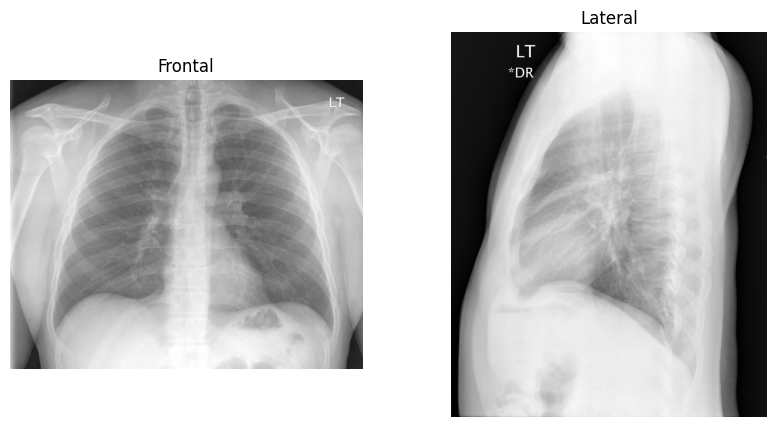

Impressions: No acute cardiopulmonary process.
Generated Report:  No evidence of active disease.


In [54]:
compare_report(np.random.choice(test_uids))

Patient UID: 3555


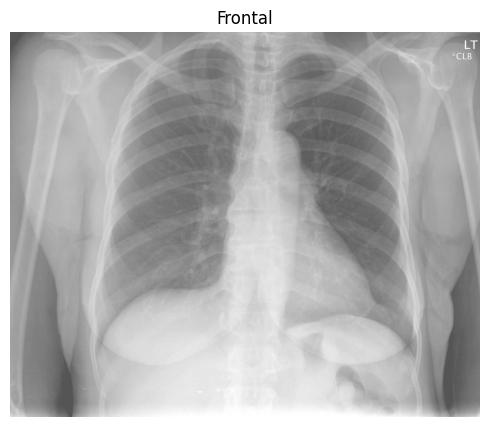

Impressions: 1. No acute cardiopulmonary disease.
Generated Report: . No evidence of active disease.


In [55]:
compare_report(3555)

Patient UID: 1212


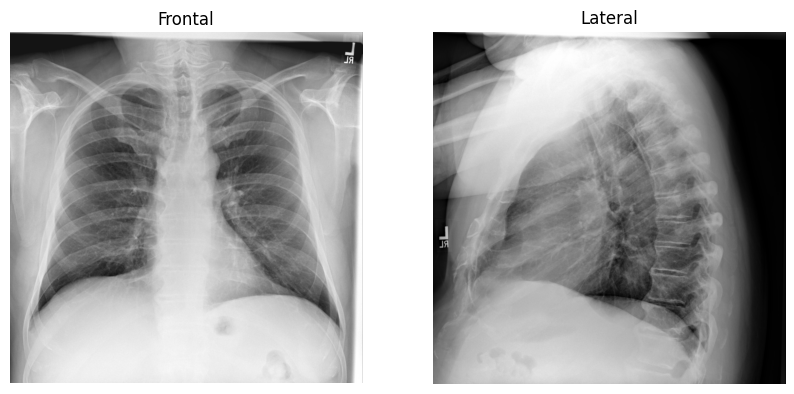

Impressions: No acute disease.
Generated Report:  No evidence of active disease.


In [56]:
compare_report(np.random.choice(test_uids))

Patient UID: 2229


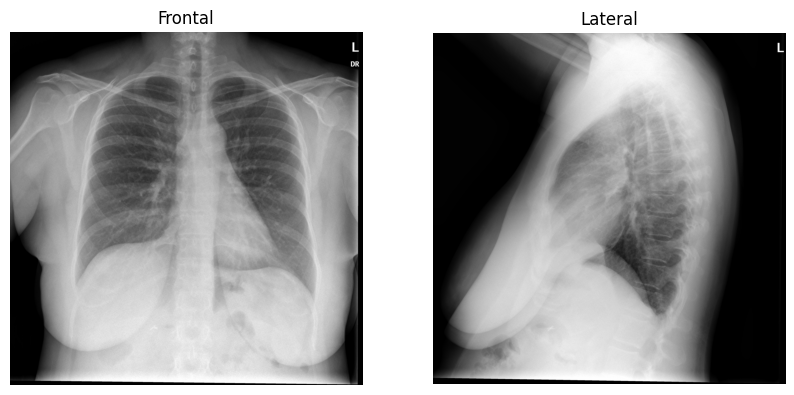

Impressions: 1. No acute radiographic cardiopulmonary process.
Generated Report: No evidence of active disease.


In [57]:
compare_report(np.random.choice(test_uids))

Patient UID: 962


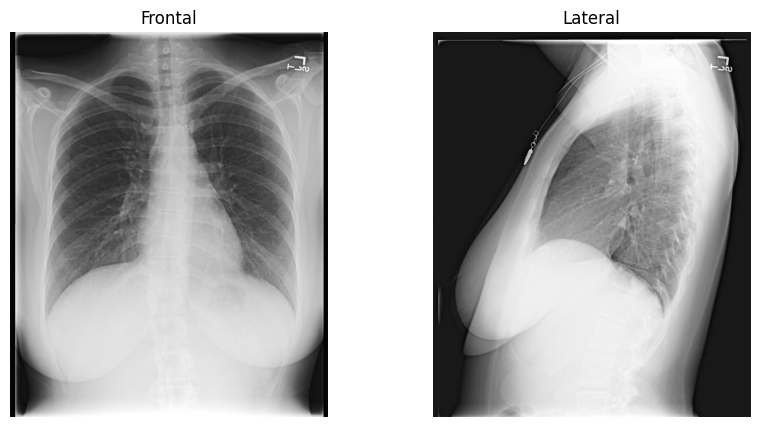

Impressions: No acute pulmonary disease.
Generated Report: No evidence of active disease.


In [58]:
compare_report(np.random.choice(test_uids))

Patient UID: 3079


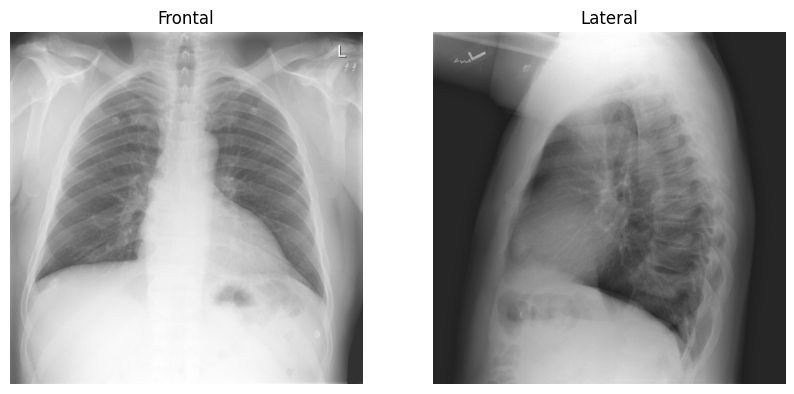

Impressions: No evidence of acute cardiopulmonary process.
Generated Report:  No evidence of active disease.


In [59]:
compare_report(np.random.choice(test_uids))

Patient UID: 1834


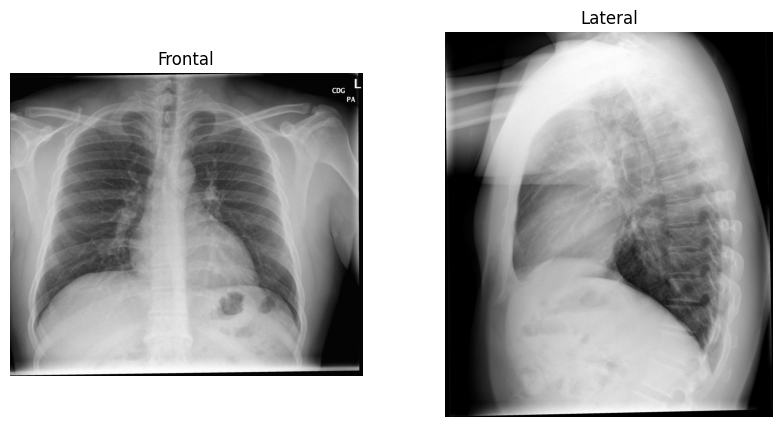

Impressions: Normal chest No evidence of tuberculosis
Generated Report: No evidence of active disease.


In [60]:
compare_report(np.random.choice(test_uids))

Patient UID: 982


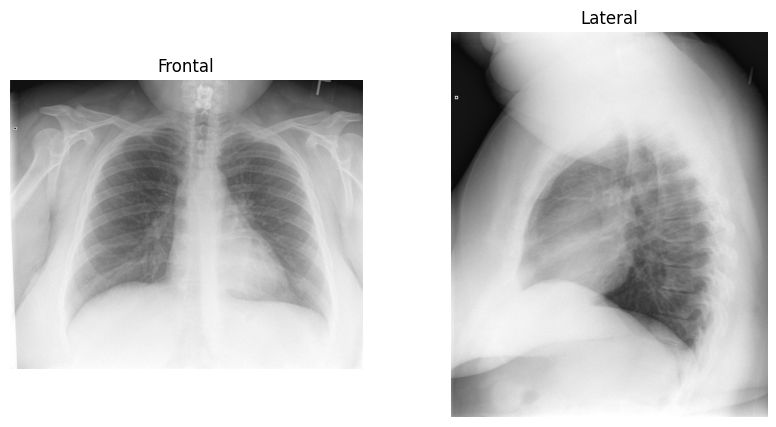

Impressions: No active disease.
Generated Report:  XXXX.


In [61]:
compare_report(np.random.choice(test_uids))

Patient UID: 1687


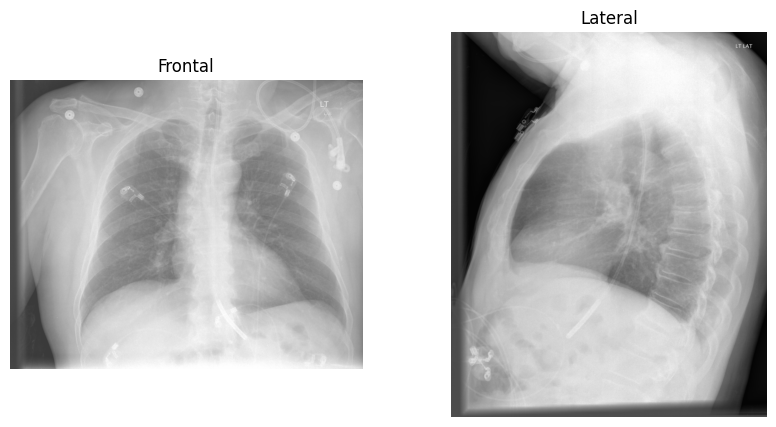

Impressions: 1. No acute cardiopulmonary abnormality. 2. Feeding tube tip XXXX distal to the gastroesophageal junction.
Generated Report:  XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.


In [62]:
compare_report(np.random.choice(test_uids))

Patient UID: 222


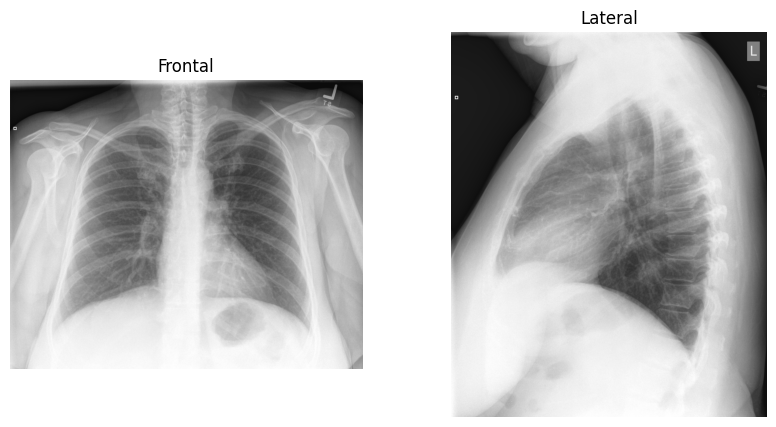

Impressions: 1. No evidence of active disease.
Generated Report:  No evidence of active disease.


In [63]:
compare_report(np.random.choice(test_uids))

Patient UID: 3191


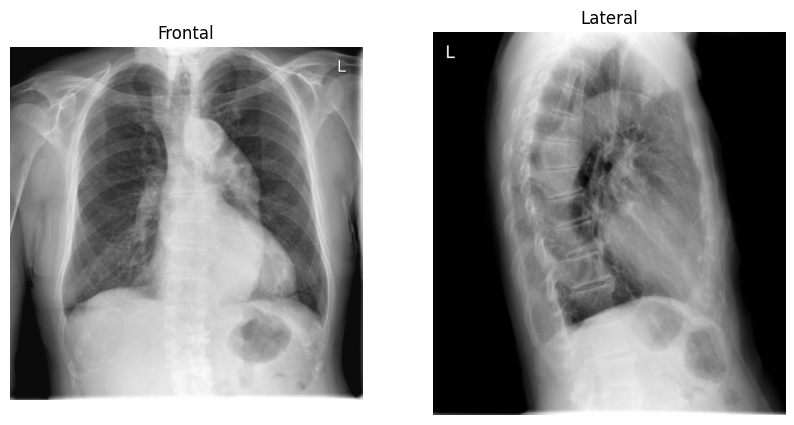

Impressions: Emphysema. No acute pulmonary findings.
Generated Report:  XXXX. No evidence of active disease.


In [64]:
compare_report(np.random.choice(test_uids))

In [65]:
def calculate_bleu_scores(test_uids):
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    smoothie = SmoothingFunction().method4
    
    for uid in test_uids:
        uid_projection_df = projections_df[projections_df.uid == uid]
        image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
        impression = reports_df[reports_df.uid == uid].impression.iloc[0]
        
        # Ensure impressions is a string
        if not isinstance(impression, str):
            print(f"Skipping UID {uid} due to non-string impression.")
            continue
        
        generated_report = generate_report(image_paths)
        
        # Tokenize the findings and generated report
        reference_tokens = [nltk.word_tokenize(impression)]
        generated_tokens = nltk.word_tokenize(generated_report)
        
        # Calculate BLEU scores
        bleu_1 = sentence_bleu(reference_tokens, generated_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu_2 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        bleu_3 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
        
        bleu_1_scores.append(bleu_1)
        bleu_2_scores.append(bleu_2)
        bleu_3_scores.append(bleu_3)
    
    avg_bleu_1 = np.mean(bleu_1_scores)
    avg_bleu_2 = np.mean(bleu_2_scores)
    avg_bleu_3 = np.mean(bleu_3_scores)
    
    return avg_bleu_1, avg_bleu_2, avg_bleu_3

# Example usage
test_uids = np.random.choice(test_uids, size=10, replace=False)  # Adjust size as needed
avg_bleu_1, avg_bleu_2, avg_bleu_3 = calculate_bleu_scores(test_uids)
print("Average BLEU-1 Score:", avg_bleu_1)
print("Average BLEU-2 Score:", avg_bleu_2)
print("Average BLEU-3 Score:", avg_bleu_3)

NameError: name 'SmoothingFunction' is not defined